<a href="https://colab.research.google.com/gist/darwinyusef/2b6a5358de792346e836558d45ba8e2e/detr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DETR in `transformers`
In this notebook, we going through a simple example of using pretrained `detr-resnet-50` to detect some objects in an image.

In [65]:
%pip install timm

In [66]:
# this example is mainly from https://huggingface.co/facebook/detr-resnet-50

from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image, ImageDraw
import requests

In [81]:
#url = "https://i.ytimg.com/vi/QeWPWyBH2Ko/maxresdefault.jpg"
#url = "http://images.cocodataset.org/val2017/000000039769.jpg"

url = "https://www.thehonestkitchen.com/cdn/shop/articles/iStock_000067889689_Medium1.jpg"
image = Image.open(requests.get(url, stream=True).raw)

### Model
We are using `facebook/detr-resnet-50`, which is a basic DETR with a relatively small ResNet backbone. It has 100 object queries, which mean it can detect a maximum of 100 objects.

In [82]:
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Processor
The processor converts the image into a dict with keys `pixel_values` and `pixel_mask`. The pixel values are usually transformed in a manner that matches the paper implementation, which may involve normalization, resizing, etc.

In [83]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
inputs = processor(images=image, return_tensors="pt")

### Outputs
The output of the model is of type `DetrObjectDetectionOutput`, which contains `logits`, `last_hidden_states`, `pred_boxes`, etc. <br>
The size of `logits` is `(batch size, n_object_queries, n_classes)`, which is used to determine the classes of the detections. This model has 100 object queries and 92 classes. The object queries that have low confidences in classes, or have a "no object" class are filtered out in the `post_process_object_detection` function. <br>
The size of `pred_boxes` is `(batch size, n_object_queries, box_dimensions)`, which is used to determine the location of the bounding box.

In [84]:
outputs = model(**inputs)

In [85]:
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]
info = []
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    info.append(model.config.id2label[label.item()])
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

Detected dog with confidence 0.955 at location [235.79, 188.22, 489.09, 432.52]
Detected dog with confidence 0.999 at location [113.11, 133.46, 312.48, 422.31]
Detected dog with confidence 0.986 at location [465.37, 23.75, 682.88, 418.37]


In [86]:
img_draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    img_draw.rectangle(((box[0], box[1]),(box[2], box[3])), outline='Red')
    img_draw.text((box[0], box[1]), model.config.id2label[label.item()], align ="left")

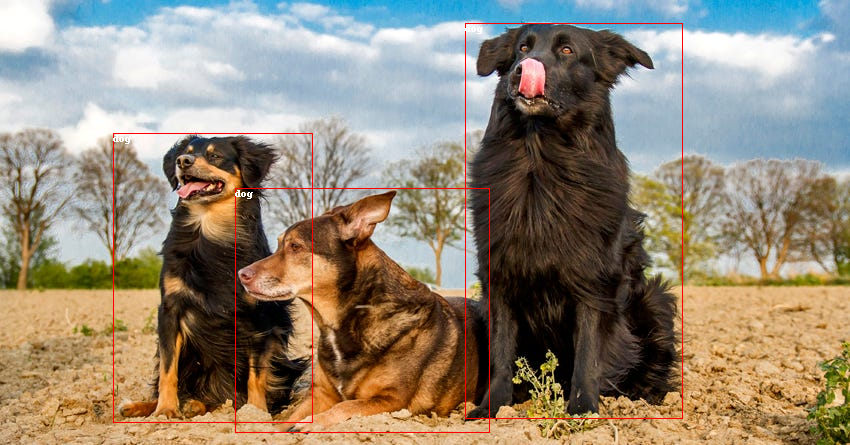

In [87]:
display(image)